# Transfer learning - Fine-tuning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Might train more than 1-3 layers

<img src='https://camo.githubusercontent.com/a30cd9d1a1f7b27a2d429dddb2a436ba4e6fd12df16b6623f3385cac6fba333b/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30352d7472616e736665722d6c6561726e696e672d666561747572652d65787472616374696f6e2d76732d66696e652d74756e696e672e706e67' />

### Data exploration

In [4]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [2]:
walk_through_dir('data/10_food_classes_10_percent')

There are 2 directories and 0 images in 'data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_10_percent\test\steak'.
There are 0 di

In [3]:
train_dir = 'data/10_food_classes_10_percent/train/'
test_dir = 'data/10_food_classes_10_percent/test/'

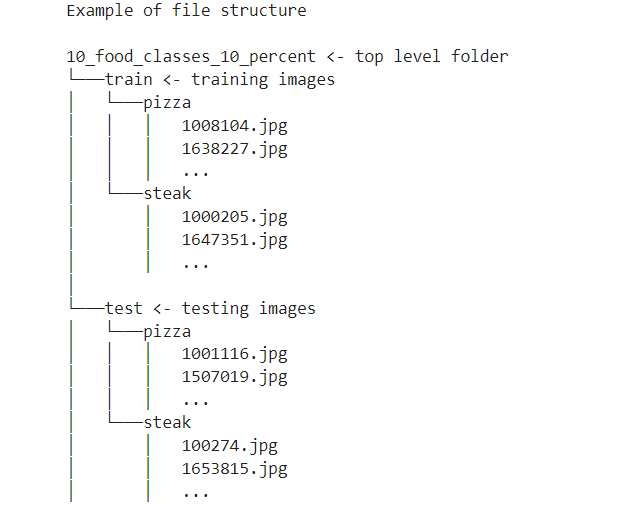

Below the `tf.keras.preprocessing.image_dataset_from_directory()` approach is used rather than the `ImageDataGenerator`. There is pretty much no difference between them, except for the object created. This approach created a `tf.data.Dataset` object rather than a generator, which is much more efficient, while the generator is performs better for larger datasets

The parameters accepted are pretty much the same too.

In [5]:
# Create data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    # Default batch size
    batch_size=32,
    # Type of labels (outputs)
    label_mode='categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

`(None, 224, 224, 3)` refer to the tensor shape of the images. `None` being the batch size, `224` being the width and height & `3` being the number of channels

`(None, 10)` refers to the tensor shape of the labels, where `10` is the number of classes

**Side-note** The batch size is always None since it is just a placeholder until its used during model training, where the `image_dataset_from_directory()` would then fill. Until then (The model is trained) it remains as None

In [7]:
# Further inspection shows more advantages
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [14]:
# Take the first batch
for images, labels in train_data.take(1):
    print(images.shape, images, labels)

(32, 224, 224, 3) tf.Tensor(
[[[[8.63418350e+01 2.43418369e+01 4.13265377e-01]
   [9.08061218e+01 2.88061237e+01 3.83163309e+00]
   [9.32806091e+01 2.90663261e+01 1.85204053e+00]
   ...
   [5.34336205e+01 2.28057671e+00 1.37741104e-01]
   [5.47652626e+01 5.76526308e+00 1.85711670e+00]
   [5.11990280e+01 2.19902682e+00 1.27563462e-01]]

  [[8.90663300e+01 2.70663261e+01 2.06632638e+00]
   [8.93520355e+01 2.83520393e+01 3.52039576e-01]
   [9.02295914e+01 2.60153065e+01 0.00000000e+00]
   ...
   [5.57703438e+01 6.22956848e+00 1.49995613e+00]
   [5.57805862e+01 6.84692430e+00 2.85202718e+00]
   [5.17857132e+01 3.78571510e+00 0.00000000e+00]]

  [[9.01377563e+01 2.91377544e+01 1.64285707e+00]
   [8.51581650e+01 2.41581631e+01 0.00000000e+00]
   [9.58775482e+01 3.18316326e+01 2.89795852e+00]
   ...
   [5.70458908e+01 8.38263607e+00 2.78573608e+00]
   [5.48418465e+01 7.08675051e+00 2.65817881e+00]
   [5.19284668e+01 6.92846680e+00 1.92846680e+00]]

  ...

  [[1.27632454e+02 6.02039223e+01 1.7

### Build model with Functional API

The Keras functional API also have models that were pretrained (on ImageNet)

In [19]:
# Create efficientnet model
base_model = tf.keras.applications.EfficientNetB0(
    # Will add our own top (output) layer
    include_top=False
)

# Freeze base model
base_model.trainable = False

# Create inputs for base model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='input_layer')

# Normalize input  (Required for Resnet, not for efficientnet: this is built in)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# Pass inputs to base model
x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')

# Add average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# Create output layer
outputs = tf.keras.layers.Dense(10, activation='linear', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_0 = model_0.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    # Validate for less data so training is faster
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback('tensorboard_logs_1', 'efficientnetB0')]
    
)

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: tensorboard_logs_1/efficientnetB0/20220923-201625
Epoch 1/5
24/24 [==============================] - 60s 2s/step - loss: 1.8743 - accuracy: 0.4053 - val_loss: 1.2971 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 51s 2s/step - loss: 1.1176 - accuracy: 0.7413 - val_loss: 0.8582 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 48s 2s/step - loss: 0.8004 - accuracy: 0.8213 - val_loss: 0.6881 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 50s 2s/step - loss: 0.6556 - accuracy: 0.8480 - val_loss: 0.5799 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 51s 2s/step - loss: 0.5539 - accuracy: 0.8787 - val_loss: 0.5386 - val_accuracy: 0.8487


The `GlobalAveragePooling2D` layer pools the outputs into a shape that is compatible with the outputs (same shape as the labels). `GlobalMaxPooling2D` can also be used, however the former is more common in practice.